In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook")

URL = "https://raw.githubusercontent.com/joestubbs/coe379L-fa25/main/datasets/unit01/project1.csv"


df = pd.read_csv(URL)

print("Shape:", df.shape)
df.head()


Shape: (131165, 12)


,Animal ID,Date of Birth,Name,DateTime,MonthYear,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A680855,5/25/14,NaN,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
1,A680857,5/25/14,NaN,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
2,A680858,5/25/14,NaN,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
3,A680859,5/25/14,NaN,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
4,A680860,5/25/14,NaN,2014-06-10T00:00:00-05:00,Jun-14,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black


In [ ]:
# Normalize column names: lowercase, underscores, no spaces
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r'[^0-9a-zA-Z]+', '_', regex=True)
      .str.replace(r'_{2,}', '_', regex=True)
      .str.strip('_')
)

print(df.columns.tolist())


['animal_id', 'date_of_birth', 'name', 'datetime', 'monthyear', 'outcome_type', 'outcome_subtype', 'animal_type', 'sex_upon_outcome', 'age_upon_outcome', 'breed', 'color']


In [ ]:
# Inspect types, duplicates, missing (normalized columns)
print(df.info())
print("\nDuplicate rows:", df.duplicated().sum())
print("\nMissing per column:\n", df.isna().sum())

# Check for blank strings in object columns
for col in df.select_dtypes(include='object').columns:
    blanks = (df[col].astype(str).str.strip() == "").sum()
    if blanks:
        print(f"Blank strings in {col}: {blanks}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131165 entries, 0 to 131164
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   animal_id         131165 non-null  object
 1   date_of_birth     131165 non-null  object
 2   name              93658 non-null   object
 3   datetime          131165 non-null  object
 4   monthyear         131165 non-null  object
 5   outcome_type      131125 non-null  object
 6   outcome_subtype   65810 non-null   object
 7   animal_type       131165 non-null  object
 8   sex_upon_outcome  131165 non-null  object
 9   age_upon_outcome  131165 non-null  object
 10  breed             131165 non-null  object
 11  color             131165 non-null  object
dtypes: object(12)
memory usage: 12.0+ MB
None

Duplicate rows: 17

Missing per column:
 animal_id               0
date_of_birth           0
name                37507
datetime                0
monthyear               0
outcome_type

In [ ]:
# Basic cleaning
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Dropped {before - after} duplicate rows")

# Drop rows with missing target
df = df.dropna(subset=["outcome_type"])

# Fill selected categoricals with mode
for c in ["sex_upon_outcome", "animal_type", "color", "outcome_subtype", "name"]:
    if c in df.columns:
        mode = df[c].mode(dropna=True)
        if not mode.empty:
            df[c] = df[c].fillna(mode[0])

print("Missing after fills:\n", df.isna().sum())


Dropped 17 duplicate rows
Missing after fills:
 animal_id           0
date_of_birth       0
name                0
datetime            0
monthyear           0
outcome_type        0
outcome_subtype     0
animal_type         0
sex_upon_outcome    0
age_upon_outcome    0
breed               0
color               0
dtype: int64


In [ ]:
# Convert age_upon_outcome -> numeric days
import re
import numpy as np

def age_to_days(s: str):
    if pd.isna(s):
        return np.nan
    s = str(s).lower().strip()
    m = re.match(r"^\s*([0-9]*\.?[0-9]+)\s*(year|years|month|months|week|weeks|day|days)\s*$", s)
    if not m:
        return np.nan
    num = float(m.group(1))
    unit = m.group(2)
    if "day" in unit:   return num
    if "week" in unit:  return num * 7
    if "month" in unit: return num * 30
    if "year" in unit:  return num * 365
    return np.nan

df["age_in_days"] = df["age_upon_outcome"].apply(age_to_days)
df[["age_upon_outcome", "age_in_days"]].head(10)


,age_upon_outcome,age_in_days
0,2 weeks,14.0
1,2 weeks,14.0
2,2 weeks,14.0
3,2 weeks,14.0
4,2 weeks,14.0
5,2 weeks,14.0
6,2 weeks,14.0
7,2 weeks,14.0
8,2 months,60.0
9,4 weeks,28.0


In [7]:
# Keep breed for EDA; we'll drop it before modeling
# Generated with AI, see Use_of_AI.md [7]
irrelevant = [c for c in ["animal_id", "date_of_birth", "datetime", "monthyear"] if c in df.columns]
df = df.drop(columns=irrelevant)
print("Remaining columns:", list(df.columns))


Remaining columns: ['name', 'outcome_type', 'outcome_subtype', 'animal_type', 'sex_upon_outcome', 'age_upon_outcome', 'breed', 'color', 'age_in_days']


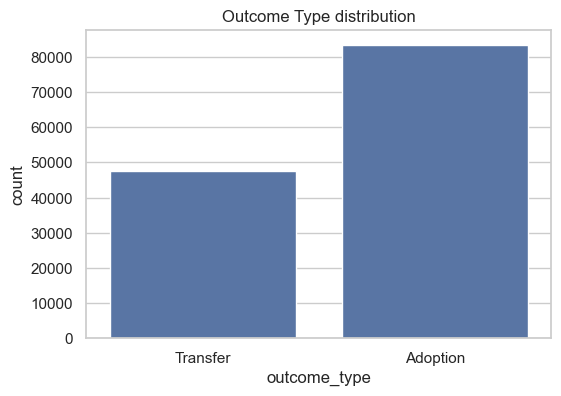

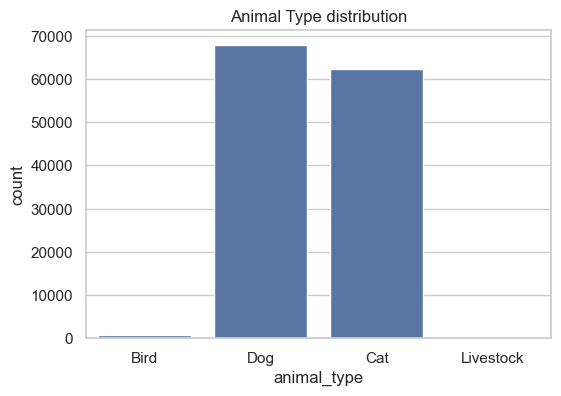

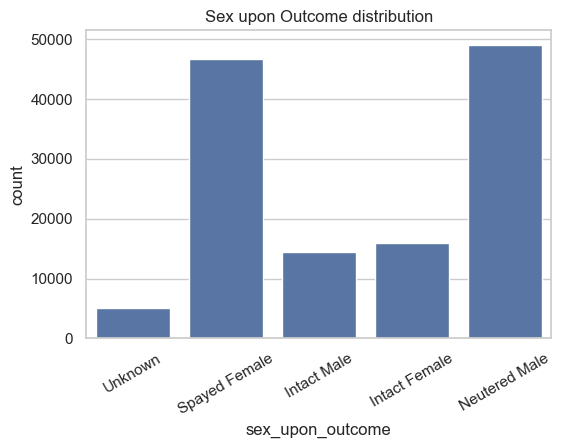

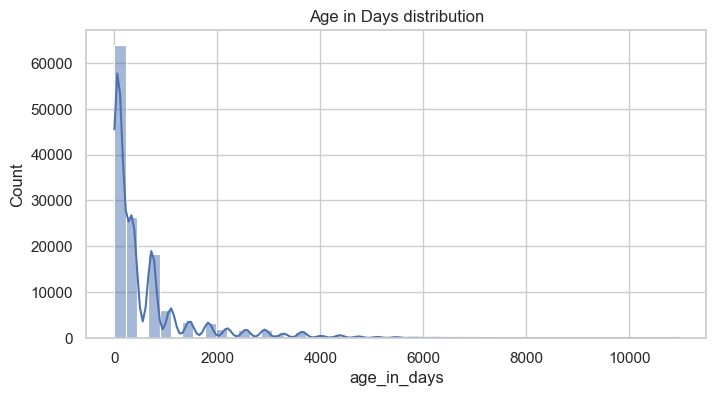

In [ ]:
# Univariate visualizations
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="outcome_type", data=df)
plt.title("Outcome Type distribution")
plt.show()

if "animal_type" in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x="animal_type", data=df)
    plt.title("Animal Type distribution")
    plt.show()

if "sex_upon_outcome" in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x="sex_upon_outcome", data=df)
    plt.title("Sex upon Outcome distribution")
    plt.xticks(rotation=30)
    plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df["age_in_days"].dropna(), bins=50, kde=True)
plt.title("Age in Days distribution")
plt.show()


In [ ]:
# One-hot demo (exclude target)
df_demo = df.copy()
df_demo["outcome_type"] = df_demo["outcome_type"].astype("category")

cat_cols = df_demo.select_dtypes(include=["object", "category"]).columns.tolist()
if "outcome_type" in cat_cols:
    cat_cols.remove("outcome_type")

df_onehot_demo = pd.get_dummies(df_demo, columns=cat_cols, drop_first=False)
print("One-hot demo shape:", df_onehot_demo.shape)
df_onehot_demo.head(3)


One-hot demo shape: (131108, 28678)


,outcome_type,age_in_days,name_#1,name_#2,name_#3,name_#3 Athena,name_#4,name_#5,name_#5 Buttercup,name_#6 Ivy,...,color_Yellow/Brown,color_Yellow/Cream,color_Yellow/Gray,color_Yellow/Green,color_Yellow/Orange,color_Yellow/Orange Tabby,color_Yellow/Red,color_Yellow/Tan,color_Yellow/White,color_Yellow/Yellow
0,Transfer,14.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Transfer,14.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Transfer,14.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Split (drop breed per spec)
from sklearn.model_selection import train_test_split

df_model = df.drop(columns=["breed"]) if "breed" in df.columns else df.copy()

y = df_model["outcome_type"]
X = df_model.drop(columns=["outcome_type"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

y.value_counts(normalize=True), y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


(outcome_type
 Adoption    0.63749
 Transfer    0.36251
 Name: proportion, dtype: float64,
 outcome_type
 Adoption    0.637492
 Transfer    0.362508
 Name: proportion, dtype: float64,
 outcome_type
 Adoption    0.63748
 Transfer    0.36252
 Name: proportion, dtype: float64)

In [ ]:
# Preprocessing (one-hot cats, scale age_in_days)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_features = [c for c in X.columns if c == "age_in_days"]
categorical_features = [c for c in X.columns if c != "age_in_days"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num",  Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), numeric_features),
        ("cat",  Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]), categorical_features),
    ],
    remainder="drop"
)


In [ ]:
# Model 1: KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn_pipe = Pipeline([("pre", preprocessor), ("clf", KNeighborsClassifier(n_neighbors=5))])
knn_pipe.fit(X_train, y_train)
print("KNN (k=5):\n", classification_report(y_test, knn_pipe.predict(X_test), digits=3))


KNN (k=5):
               precision    recall  f1-score   support

    Adoption      0.866     0.931     0.897     16716
    Transfer      0.860     0.748     0.800      9506

    accuracy                          0.864     26222
   macro avg      0.863     0.839     0.849     26222
weighted avg      0.864     0.864     0.862     26222



In [ ]:
# Model 2 - KNN with GridSearchCV (ultra-light version)

from sklearn.model_selection import GridSearchCV, train_test_split

# --- Tiny subsample for grid search (2,000 rows max) ---
X_train_tiny, _, y_train_tiny, _ = train_test_split(
    X_train, y_train,
    train_size=2000,        # cap at 2000 rows
    stratify=y_train,
    random_state=42
)

param_grid = {"clf__n_neighbors": [3, 5, 7]}   # fewer values to search

grid = GridSearchCV(
    estimator=knn_pipe,
    param_grid=param_grid,
    cv=2,                  # just 2 folds
    scoring="f1_macro",
    n_jobs=1               # single-thread to reduce CPU/RAM spikes
)

grid.fit(X_train_tiny, y_train_tiny)

print("Best params:", grid.best_params_)
print("KNN (GridSearchCV tiny subset):\n",
      classification_report(y_test, grid.predict(X_test), digits=3))


Best params: {'clf__n_neighbors': 7}
KNN (GridSearchCV tiny subset):
               precision    recall  f1-score   support

    Adoption      0.846     0.905     0.875     16716
    Transfer      0.810     0.711     0.757      9506

    accuracy                          0.835     26222
   macro avg      0.828     0.808     0.816     26222
weighted avg      0.833     0.835     0.832     26222



In [ ]:
# Model 3 - Logistic Regression (safe version)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Pipeline with preprocessor from earlier cells
logreg_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(
        max_iter=1000,
        solver="saga",   # efficient with sparse one-hot data
        n_jobs=-1        # parallelize across CPU cores
    ))
])

# Fit on full training set
logreg_pipe.fit(X_train, y_train)

# Predict on test set
y_pred_lr = logreg_pipe.predict(X_test)

print("Logistic Regression:\n", classification_report(y_test, y_pred_lr, digits=3))


Logistic Regression:
               precision    recall  f1-score   support

    Adoption      0.868     0.963     0.913     16716
    Transfer      0.919     0.742     0.821      9506

    accuracy                          0.883     26222
   macro avg      0.893     0.852     0.867     26222
weighted avg      0.886     0.883     0.879     26222



In [ ]:
# Comparison table

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

def get_metrics(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return {"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

results = []
results.append(get_metrics("KNN (k=5)", y_test, knn_pipe.predict(X_test)))
results.append(get_metrics("KNN (Grid)", y_test, grid.predict(X_test)))
results.append(get_metrics("LogReg", y_test, logreg_pipe.predict(X_test)))

pd.DataFrame(results)


,Model,Accuracy,Precision,Recall,F1
0,KNN (k=5),0.864427,0.863235,0.839262,0.848713
1,KNN (Grid),0.834528,0.827879,0.807825,0.815751
2,LogReg,0.882656,0.893292,0.852266,0.866816
